In [1]:
# Import necessary packages
import os
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import tensorflow as tf
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, LeakyReLU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

os.chdir("/home/maina/Documents/Air Pollution Monitoring")

# import data_retrival and analysis functions
from data_analysis import *

2022-01-13 14:07:14.757731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-13 14:07:14.757758: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Gets the data from firebase, process it and store it in a csv file
filepath = read_data()

# Read the dataset as a pandas dataframe
df = pd.read_csv(filepath)

# Display the first 10 rows
df.head(10)

,timestamp,mq7,mq135,temperature,humidity
0,1639922725,162.0,39.0,24.1,73.0
1,1639923325,135.0,38.0,23.9,75.0
2,1639923927,118.0,36.0,24.0,72.0
3,1639924555,109.0,39.0,24.4,73.0
4,1639925428,102.0,42.0,24.2,74.0
5,1639926056,100.0,42.0,24.2,76.0
6,1639926658,97.0,40.0,24.2,75.0
7,1639927411,96.0,37.0,24.0,77.0
8,1639928191,92.0,37.0,23.9,77.0
9,1639928791,92.0,37.0,23.9,77.0


In [3]:
# Converting the unix time stamp to datetime format
df["timestamp"] = pd.to_datetime(df['timestamp'], unit='s')
df["timestamp"] = df["timestamp"].dt.tz_localize('Africa/Nairobi')
df.head()

,timestamp,mq7,mq135,temperature,humidity
0,2021-12-19 14:05:25+03:00,162.0,39.0,24.1,73.0
1,2021-12-19 14:15:25+03:00,135.0,38.0,23.9,75.0
2,2021-12-19 14:25:27+03:00,118.0,36.0,24.0,72.0
3,2021-12-19 14:35:55+03:00,109.0,39.0,24.4,73.0
4,2021-12-19 14:50:28+03:00,102.0,42.0,24.2,74.0


In [40]:
# Resapmle dataset hourly using mean
raw_df = df.set_index("timestamp")
df = raw_df.resample(rule='H').mean()
df

,mq7,mq135,temperature,humidity
timestamp,,,,
2021-12-19 14:00:00+03:00,125.200000,38.800000,24.120000,73.400000
2021-12-19 15:00:00+03:00,95.000000,38.500000,23.983333,76.666667
2021-12-19 16:00:00+03:00,90.166667,36.166667,23.266667,77.666667
2021-12-19 17:00:00+03:00,97.200000,39.800000,23.240000,78.400000
2021-12-19 18:00:00+03:00,95.500000,39.500000,23.233333,79.833333
...,...,...,...,...
2022-01-03 01:00:00+03:00,75.000000,37.400000,22.600000,64.280000
2022-01-03 02:00:00+03:00,67.666667,34.833333,22.766667,60.800000
2022-01-03 03:00:00+03:00,54.000000,30.250000,23.637500,52.500000


In [5]:
# Check if there are any missing values in the dataset
df.isnull().sum()

mq7            0
mq135          0
temperature    0
humidity       0
dtype: int64

In [6]:
# Statistical summary of the dataset columns
df.describe()

,mq7,mq135,temperature,humidity
count,352.000000,352.000000,352.000000,352.000000
mean,87.077023,42.029334,24.492894,62.310476
std,13.675241,7.418984,2.496454,10.194331
min,51.750000,27.833333,21.012821,29.800000
25%,79.437500,38.250000,22.991667,58.005357
50%,84.400000,40.200000,23.837500,66.055000
75%,91.312500,43.350000,25.227841,67.862672
max,153.166667,88.500000,34.000000,81.333333


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>],
      dtype=object)

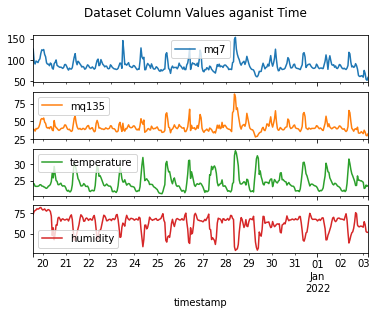

In [7]:
# plot the values against time
df[["mq7", "mq135", "temperature", "humidity"]].plot(subplots=True, title="Dataset Column Values aganist Time")

In [8]:
scaler = MinMaxScaler()
df.reset_index(inplace=True)
scaled_data = scaler.fit_transform(df.drop("timestamp", axis=1))
scaled_data

array([[0.72423993, 0.18076923, 0.23924975, 0.84605433],
       [0.4264585 , 0.17582418, 0.22872655, 0.90944373],
       [0.37880033, 0.13736264, 0.17354393, 0.92884864],
       ...,
       [0.0221857 , 0.03983516, 0.20209773, 0.44049159],
       [0.        , 0.02747253, 0.17418559, 0.42108668],
       [0.06557108, 0.07197802, 0.18997038, 0.42302717]])

In [9]:
x = scaled_data
y = scaled_data[:,0]
y1 = scaled_data[:,1]


print(x.shape, y.shape, y1.shape)

(352, 4) (352,) (352,)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=False)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y1, test_size=0.2, random_state=123, shuffle=False)

In [11]:
window_length = 6
num_features = 4
batch_size = 16
train_generator = TimeseriesGenerator(x_train, y_train, length=window_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=window_length, sampling_rate=1, batch_size=batch_size)

train_generator1 = TimeseriesGenerator(x_train1, y_train1, length=window_length, sampling_rate=1, batch_size=batch_size)
test_generator1 = TimeseriesGenerator(x_test1, y_test1, length=window_length, sampling_rate=1, batch_size=batch_size)

In [12]:
def make_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(window_length, num_features), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(LSTM(128, return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Dense(1))

    model.summary()
    return model

In [13]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    mode="min"
                              )
mq7_model = make_model()
mq7_model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

2022-01-13 14:07:19.555890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-13 14:07:19.555933: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-13 14:07:19.555964: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Pavilion): /proc/driver/nvidia/version does not exist
2022-01-13 14:07:19.556314: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 128)            68096     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 6, 128)            0         
                                                                 
 dropout (Dropout)           (None, 6, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 6, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 6, 64)             0

In [14]:
mq135_model = make_model()
mq135_model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 6, 128)            68096     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 6, 128)            131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 6, 128)            0         
                                                                 
 dropout_2 (Dropout)         (None, 6, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 6, 64)             49408     
                                                                 
 dropout_3 (Dropout)         (None, 6, 64)            

In [15]:
history1 = mq7_model.fit(
    train_generator, 
    epochs=100,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping]
                             )

Epoch 1/100
18/18 [==============================] - 5s 83ms/step - loss: 0.0807 - mae: 0.2387 - val_loss: 0.0357 - val_mae: 0.1520
Epoch 2/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0415 - mae: 0.1552 - val_loss: 0.0290 - val_mae: 0.1360
Epoch 3/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0311 - mae: 0.1280 - val_loss: 0.0234 - val_mae: 0.1186
Epoch 4/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0258 - mae: 0.1155 - val_loss: 0.0217 - val_mae: 0.1135
Epoch 5/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0236 - mae: 0.1107 - val_loss: 0.0197 - val_mae: 0.1058
Epoch 6/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0220 - mae: 0.1056 - val_loss: 0.0186 - val_mae: 0.1013
Epoch 7/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0210 - mae: 0.1029 - val_loss: 0.0176 - val_mae: 0.0973
Epoch 8/100
18/18 [==============================] - 0s 17ms/step - loss: 0.

In [16]:
history2 = mq135_model.fit(
    train_generator1, 
    epochs=100,
    validation_data=test_generator1,
    shuffle=False,
    callbacks=[early_stopping]
                             )

Epoch 1/100
18/18 [==============================] - 5s 74ms/step - loss: 0.0388 - mae: 0.1569 - val_loss: 0.0176 - val_mae: 0.1005
Epoch 2/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0245 - mae: 0.1082 - val_loss: 0.0161 - val_mae: 0.0988
Epoch 3/100
18/18 [==============================] - 0s 18ms/step - loss: 0.0214 - mae: 0.0988 - val_loss: 0.0127 - val_mae: 0.0816
Epoch 4/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0192 - mae: 0.0926 - val_loss: 0.0121 - val_mae: 0.0799
Epoch 5/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0181 - mae: 0.0883 - val_loss: 0.0121 - val_mae: 0.0816
Epoch 6/100
18/18 [==============================] - 0s 18ms/step - loss: 0.0176 - mae: 0.0871 - val_loss: 0.0117 - val_mae: 0.0791
Epoch 7/100
18/18 [==============================] - 0s 17ms/step - loss: 0.0172 - mae: 0.0862 - val_loss: 0.0112 - val_mae: 0.0759
Epoch 8/100
18/18 [==============================] - 0s 17ms/step - loss: 0.

In [17]:
mq7_model.evaluate(test_generator)

5/5 [==============================] - 0s 7ms/step - loss: 0.0159 - mae: 0.0912


[0.015884211286902428, 0.09115239977836609]

In [18]:
mq135_model.evaluate(test_generator1)

5/5 [==============================] - 0s 4ms/step - loss: 0.0105 - mae: 0.0733


[0.010534746572375298, 0.07331150770187378]

In [19]:
mq7_preds = mq7_model.predict(test_generator)
mq7_preds = mq7_preds.reshape(mq7_preds.shape[0], window_length)
mq7_preds.shape

(65, 6)

In [20]:
mq135_preds = mq135_model.predict(test_generator1)
mq135_preds = mq135_preds.reshape(mq135_preds.shape[0], window_length)
mq135_preds.shape

(65, 6)

In [38]:
df_mq7 = pd.concat([pd.DataFrame(mq7_preds[:,0]), pd.DataFrame(x_test[:,1:][window_length:])], axis=1)
reverse_transform = scaler.inverse_transform(df_mq7)
df_mq7_final = raw_df[df_mq7.shape[0]*-1:]
df_mq7_final["mq7_Predicted"] = reverse_transform[:,1]
df_mq7_final

/tmp/ipykernel_18894/3887288328.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,mq7,mq135,temperature,humidity,mq7_Predicted
timestamp,,,,,
2022-01-02 18:35:22+03:00,69.0,35.0,24.6,62.1,39.500000
2022-01-02 18:51:25+03:00,72.0,36.0,24.3,64.1,38.400000
2022-01-02 18:59:30+03:00,61.0,33.0,25.7,56.0,40.500000
2022-01-02 19:14:23+03:00,78.0,38.0,23.7,68.2,39.800000
2022-01-02 19:19:53+03:00,60.0,32.0,25.5,56.0,39.000000
...,...,...,...,...,...
2022-01-03 05:02:50+03:00,55.0,32.0,24.6,47.0,37.400000
2022-01-03 05:07:57+03:00,60.0,33.0,24.2,48.0,34.833333
2022-01-03 05:23:17+03:00,62.0,33.0,23.8,51.0,30.250000


In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_mq7_final.index, y=df_mq7_final.mq7,
                    mode='lines',
                    name='Actual'))
fig.add_trace(go.Scatter(x=df_mq7_final.index, y=df_mq7_final.mq7_Predicted,
                    mode='lines',
                    name='Predicted'))
fig.update_xaxes(title_text='Date/Time')
fig.update_yaxes(title_text="Parts Per Million")
fig.update_layout(
    title={
        'text': "MQ7 Sensor Data vs Predicted Values against Time",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })
fig.show()

In [35]:
df_mq135 = pd.concat([pd.DataFrame(mq135_preds[:,1]), pd.DataFrame(x_test[:,1:][window_length:])], axis=1)
reverse_transform1 = scaler.inverse_transform(df_mq135)
df_mq135_final = raw_df[df_mq135.shape[0]*-1:]
df_mq135_final["mq135_Predicted"] = reverse_transform1[:,1]
df_mq135_final

/tmp/ipykernel_18894/3739446238.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,mq7,mq135,temperature,humidity,mq135_Predicted
timestamp,,,,,
2022-01-02 18:35:22+03:00,69.0,35.0,24.6,62.1,39.500000
2022-01-02 18:51:25+03:00,72.0,36.0,24.3,64.1,38.400000
2022-01-02 18:59:30+03:00,61.0,33.0,25.7,56.0,40.500000
2022-01-02 19:14:23+03:00,78.0,38.0,23.7,68.2,39.800000
2022-01-02 19:19:53+03:00,60.0,32.0,25.5,56.0,39.000000
...,...,...,...,...,...
2022-01-03 05:02:50+03:00,55.0,32.0,24.6,47.0,37.400000
2022-01-03 05:07:57+03:00,60.0,33.0,24.2,48.0,34.833333
2022-01-03 05:23:17+03:00,62.0,33.0,23.8,51.0,30.250000


In [36]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_mq135_final.index, y=df_mq135_final.mq135,
                    mode='lines',
                    name='Actual'))
fig.add_trace(go.Scatter(x=df_mq135_final.index, y=df_mq135_final.mq135_Predicted,
                    mode='lines',
                    name='Predicted'))
fig.update_xaxes(title_text='Date/Time')
fig.update_yaxes(title_text="Parts Per Million")
fig.update_layout(
    title={
        'text': "MQ135 Sensor Data vs Predicted Values against Time",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })
fig.show()

In [25]:
mq7_model.save("models/mq7_model.h5")

In [31]:
mq135_model.save("models/mq135_model.h5")

In [33]:
reverse_transform1.shape

(65, 4)